In [1]:
import sys
import os
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/mnist')
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/Node_Layer_Network')
from Node_Layer_Network.Networks.multi_layer_net_extend import MultiLayerNetExtend as MLE1
from Node_Layer_Network.Networks.simple_convnet import SimpleConvNet as CVS1
from Node_Layer_Network.Networks.deep_convnet import DeepConvNet as CVD1
from mnist.common.multi_layer_net_extend import MultiLayerNetExtend as MLE2
from mnist.ch07.simple_convnet import SimpleConvNet as CVS2
from mnist.ch08.deep_convnet import DeepConvNet as CVD2
import matplotlib.pyplot as plt
from mnist.dataset.mnist import load_mnist
from mnist.common.util import smooth_curve
from mnist.common.optimizer import *
import numpy as np
import time


In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# x_train = x_train[:1000]
# t_train = t_train[:1000]
train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 128
max_iterations = 1000
print_iter = 10
mi = np.arange(max_iterations)

In [3]:
def test(test_list, max_acc=None):
    networks = {}
    train_acc = {}
    train_loss = {}
    test_acc = {}
    test_loss = {}
    optimizer = {}
    total_step = {}
    time_record = {}

    for key in test_list.keys():
        # 기록 리스트 생성
        train_acc[key] = []
        train_loss[key] = []
        test_acc[key] = []
        test_loss[key] = []
        total_step[key] = 0
        time_record[key] = 0

        # nSigmoid 경우 파라미터
        # key == 'nSigmoid_8' -> act = nSigmoid, threshold = 8
        networks[key] = test_list[key]['network']

        # optimizer 생성
        opt = test_list[key]['opt']
        lr = test_list[key]['lr']
        if opt == 'SGD':
            optimizer[key] = SGD(lr)
        elif opt == 'Momentum':
            optimizer[key] = Momentum(lr)
        elif opt == 'AdaGrad':
            optimizer[key] = AdaGrad(lr)
        elif opt == 'Adam':
            optimizer[key] = Adam(lr)
        else:
            assert 'no opt' + opt

    # 파라미터 통일
    # networks1 = networks['My']
    # networks2 = networks['Text']
    # for k in networks1.params.keys():
    #     for i in range(networks1.params[k].shape[0]):
    #         networks1.params[k][i] = networks2.params[k][i].copy()
    # networks['My'].params['W1'][0][0] = 100
    # print(networks['My'].params['W1'] - networks['Text'].params['W1'])

    # 학습
    for i in range(max_iterations):
        # if 0 not in total_step.values():
        #     print("All test list training Done\nStep: " + str(i))
        #     break

        # mini-batch train
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # mini-batch test
        batch_mask_t = np.random.choice(test_size, batch_size)
        x_batch_t = x_test[batch_mask_t]
        t_batch_t = t_test[batch_mask_t]

        # print_iter 회마다 경과 출력
        if i % print_iter == 0:
            print( "="*15 + "iteration:" + str(i) + "="*15)
            print("{:^9}|{:^9}|{:^9}|{:^9}".format('model','time','acc','loss'))

        # 학습 & 추론 & 기록
        for key in test_list.keys():
            if total_step[key] != 0:
                # Max acc 에 도달해 학습이 끝난 test model
                continue
            else:
                start = time.time()
                # CV 모델 데이터 처리
                if isinstance(networks[key], (CVS1, CVS2, CVD1, CVD2)):
                    x_batch = x_batch.reshape(-1, 1, 28, 28)
                    x_batch_t = x_batch_t.reshape(-1, 1, 28, 28)

                # 학습(역전파)
                grads = networks[key].gradient(x_batch, t_batch)
                optimizer[key].update(networks[key].params, grads)

                # 추론(순전파)
                if isinstance(networks[key], (MLE1, CVS1, CVD1)):
                    tr_acc, tr_loss = networks[key].acc_and_loss(x_batch, t_batch)
                    ts_acc, ts_loss = networks[key].acc_and_loss(x_batch_t, t_batch_t)
                else:
                    if isinstance(networks[key], (CVS1, CVS2, CVD1, CVD2)):
                        tr_acc = networks[key].accuracy(x_batch, t_batch, batch_size)
                        ts_acc = networks[key].accuracy(x_batch_t, t_batch_t, batch_size)
                    else:
                        tr_acc = networks[key].accuracy(x_batch, t_batch)
                        ts_acc = networks[key].accuracy(x_batch_t, t_batch_t)
                    tr_loss = networks[key].loss(x_batch, t_batch)
                    ts_loss = networks[key].loss(x_batch_t, t_batch_t)

                # 기록
                train_acc[key].append(tr_acc)
                train_loss[key].append(tr_loss)
                test_acc[key].append(ts_acc)
                test_loss[key].append(ts_loss)
                end = time.time()
                time_record[key] += (end-start)

                # max accuracy 도달 해당 모델 학습 종료
                if max_acc and max_acc <= ts_acc:
                    total_step[key] = i
                    print(key + " training end!\nacc : " + str(ts_acc) + " step: " + str(i))

                # print_iter 회마다 경과 출력
                if i % print_iter == 0:
                    print("{:^9}| {:0<7.3f} | {:0<.5f} | {:0<.5f}".format(key, time_record[key],ts_acc,ts_loss))

    return train_acc, train_loss, test_acc, test_loss, total_step


def plot(label, datas, t_list, *y_lim):
    for key in t_list:
        plt.plot( smooth_curve(datas[key]), markevery=50, label=key)
    plt.xlabel("iterations")
    plt.ylabel(label)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.show()

In [4]:
net1 = MLE2(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10,
            use_dropout=True, dropout_ration=0.5,
            activation='relu', weight_init_std='he', use_batchnorm=False)
# net2 = MLE1(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10,
#             use_dropout=do, dropout_ration=dr,
#             activation=act, weight_init_std=std, use_batchnorm=bn)
# net1 = CVD1(back_eta=False)
net2 = CVS2(dropout_ration=0.5)
net3 = CVD2(dropout_ration=0.5)

In [5]:
test_list = {
             'MLP':
                 {'network':net1,'opt':'AdaGrad','lr':0.01},
             'Smpl CNN':
                 {'network':net2,'opt':'AdaGrad','lr':0.01},
             'Deep CNN':
                 {'network':net3,'opt':'AdaGrad','lr':0.01},
             }


train_acc, train_loss, test_acc, test_loss, total_step = test(test_list, 0.98)

===============iteration:0===============
  model  |  time   |   acc   |  loss   
   MLP   | 0.02000 | 0.14062 | 2.28110
Smpl CNN | 0.92600 | 0.17969 | 2.29613
Deep CNN | 4.07500 | 0.09375 | 3.46771
===============iteration:10===============
  model  |  time   |   acc   |  loss   
   MLP   | 0.19000 | 0.32812 | 2.20277
Smpl CNN | 10.2040 | 0.72656 | 1.63102
Deep CNN | 57.7600 | 0.34375 | 2.27769
===============iteration:20===============
  model  |  time   |   acc   |  loss   
   MLP   | 0.42900 | 0.37500 | 1.94242
Smpl CNN | 19.5880 | 0.75000 | 1.25136
Deep CNN | 108.057 | 0.30469 | 2.14483
===============iteration:30===============
  model  |  time   |   acc   |  loss   
   MLP   | 0.58800 | 0.49219 | 1.63839
Smpl CNN | 28.6910 | 0.81250 | 1.01182
Deep CNN | 158.513 | 0.49219 | 1.87670
===============iteration:40===============
  model  |  time   |   acc   |  loss   
   MLP   | 0.72900 | 0.54688 | 1.46295
Smpl CNN | 37.9590 | 0.78125 | 0.89846
Deep CNN | 208.255 | 0.78125 | 1.31129
=

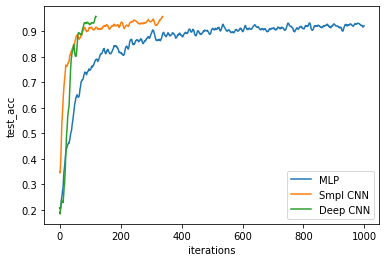

In [6]:
plot('test_acc', test_acc, test_list)

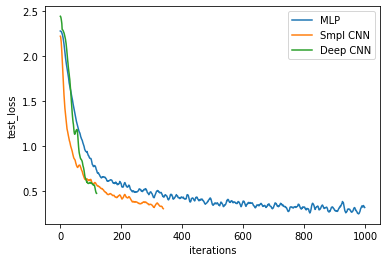

In [7]:
plot('test_loss', test_loss, test_list)

In [8]:
print(total_step)

{'MLP': 0, 'Smpl CNN': 338, 'Deep CNN': 119}


In [9]:
# plt.subplot(1,2,1)
#
# plt.plot( smooth_curve(train_acc['My']), markevery=50, label='My')
# plt.xlabel("iterations")
# plt.ylabel('train_acc')
# plt.legend()
#
# plt.subplot(1,2,2)
# plt.plot( smooth_curve(train_acc['Text']), markevery=50, label='Text')
# plt.legend()
# plt.show()